In [1]:
''' Test model '''

' Test model '

In [23]:
import torch
job_num="86"
fp=f"/Volumes/LaCie/model_job{job_num}/losses.pth"
checkpoint = torch.load(fp, map_location=torch.device('cpu'))
train_losses=checkpoint['train_losses']
valid_losses=checkpoint['valid_losses']

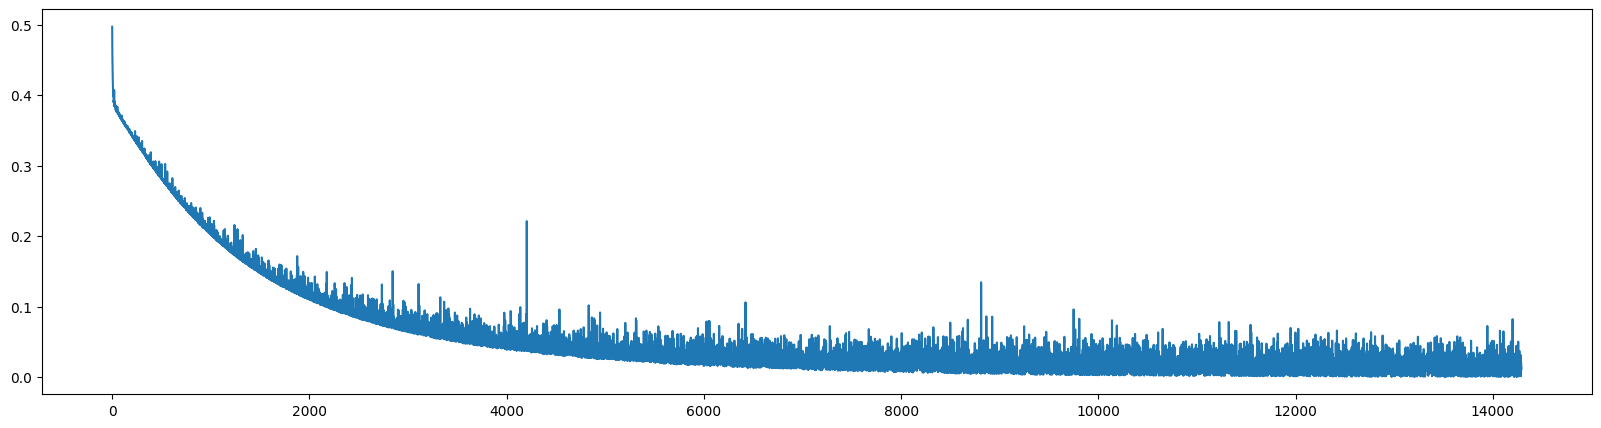

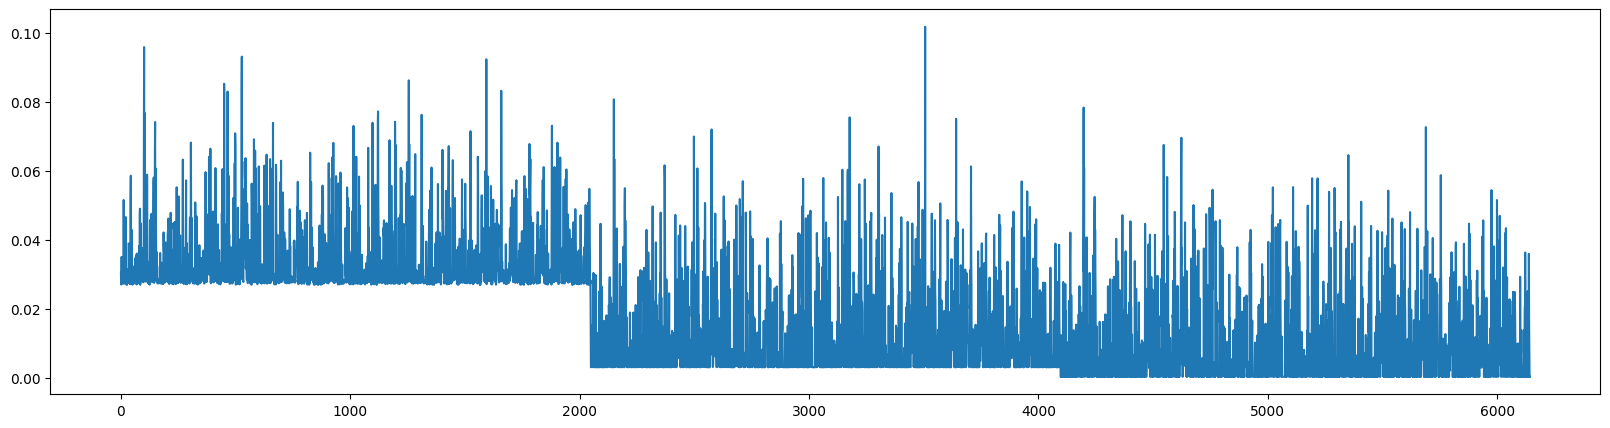

In [24]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(train_losses)
plt.show()
plt.plot(valid_losses)

In [25]:
import models
import utilities

# --- reload the modules
import importlib
importlib.reload(models)
importlib.reload(utilities)
# --- end of reload

from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model_name = "model_job84"
epoch=17
fp=f"/Volumes/LaCie/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/Users/huayinluo/Documents/code/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
# fp=f"/home/huayin/Documents/gapjncsegmentation/models/{model_name}_epoch_{epoch}.pth"
model, optimizer, epoch, loss, batch_size, lr, focal_loss_weights = load_checkpoint(model, optimizer, fp)
model = model.eval()

In [27]:
from dataset import SliceDataset
import numpy as np
import os
from dataset import *
from utilities_train import *

data_dir = "/Volumes/LaCie/select_dauer_data_256"
train_dataset, valid_dataset, train_loader, valid_loader = setup_datasets_and_dataloaders(data_dir, batch_size=1, num_workers=0)
results_dir = "results/dauer_data_256"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(len(train_dataset), len(valid_dataset))

13267 8192


In [58]:
k = 180
found_img = False
while not found_img:
    img, mask = train_dataset[k] # (label, depth, height, width)
    print(img.shape, mask.shape)
    depth = img.shape[1]
    if img.shape[2] != 256 or img.shape[3] != 256:
        k+=1
        continue
    else:
        print("k", k)
        found_img=True

torch.Size([1, 3, 256, 212]) torch.Size([2, 3, 256, 212])
torch.Size([1, 3, 256, 256]) torch.Size([2, 3, 256, 256])
k 181


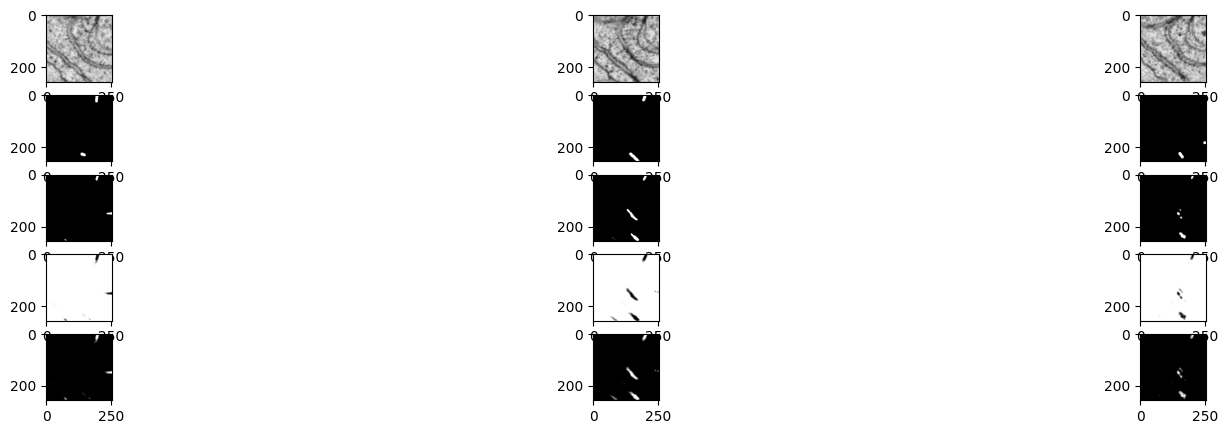

In [59]:
intermediate_pred, pred = model(img)
pred_max = torch.argmax(pred[0], dim=0) # (depth, height, width)
fig, ax = plt.subplots(5, depth)
visualize_3d_slice(img[0], ax[0])
visualize_3d_slice(mask[1], ax[1])
visualize_3d_slice(pred_max, ax[2])
visualize_3d_slice(pred[0,0].detach(), ax[3])
visualize_3d_slice(pred[0,1].detach(), ax[4])

In [66]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
total_accuracy = 0
total_precision = 0
total_recall = 0
total_iou = 0
total_tp = 0
total_fp = 0
total_tn = 0
total_fn = 0
# num_samples = 3
num_samples = len(valid_dataset)

for i in range(num_samples):
    # get prediction
    image, mask = valid_dataset[i] # (channels, depth, height, width)
    image, mask = image.to(DEVICE), mask.to(DEVICE)
    intermediate_pred, pred = model(image)
    pred = torch.argmax(pred[0], dim=0) # (depth, height, width)
    
    # calculate the metrics
    iou = get_iou(pred=pred, target=mask[1])
    accuracy = get_accuracy(pred=pred, target=mask[1])
    precision = get_precision(pred=pred, target=mask[1])
    recall = get_recall(pred=pred, target=mask[1])
    tp, fp, tn, fn = get_confusion_matrix(pred=pred, target=mask[1])
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_iou += iou
    total_tp += tp
    total_fp += fp
    total_tn += tn
    
    # save the results
    fig, ax = plt.subplots(3, 5, figsize=(15, 5), num=f"valid_{i}")
    visualize_3d_slice(image[0], ax[0], "Input")
    visualize_3d_slice(mask[0], ax[1], "Label")
    visualize_3d_slice(pred, ax[2], "Prediction")
    plt.savefig(f"{results_dir}/valid_{i}.png")
    plt.close("all")
    
    print(f"TP = {tp}, FP = {fp}, TN = {tn}, FN = {fn}")
    print(f"Valid {i}: accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, iou={iou:.4f} | progress: {100*(i+1)/num_samples:.2f}%")
avg_accuracy = total_accuracy / num_samples
avg_precision = total_precision / num_samples
avg_recall = total_recall / num_samples
avg_iou = total_iou / num_samples
avg_tp = total_tp / num_samples
avg_fp = total_fp / num_samples
avg_tn = total_tn / num_samples
avg_fn = total_fn / num_samples
print(f"AVERAGE accuracy: {avg_accuracy:.4f}, precision: {avg_precision:.4f}, recall: {avg_recall:.4f}, iou: {avg_iou:.4f}")


TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 0: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 12.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 1: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 25.00%
TP = 239.0, FP = 19.0, TN = 204.0, FN = 20018.0
Valid 2: accuracy=0.9891113042831421, precision=0.9263566136360168, recall=0.5395033955574036, iou=0.5173160433769226 | progress: 37.50%
TP = 0.0, FP = 0.0, TN = 9.0, FN = 20471.0
Valid 3: accuracy=0.999560534954071, precision=1.0, recall=1.111110989882036e-07, iou=1.111110989882036e-07 | progress: 50.00%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 4: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 62.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 5: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 75.00%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Valid 6: accuracy=1.0, precision=1.0, recall=1.0, iou=1.0 | progress: 87.50%
TP = 0.0, FP = 0.0, TN = 0.0, FN = 20480.0
Va

In [49]:
iou = get_iou(pred=pred, target=mask[1])
accuracy = get_accuracy(pred=pred, target=mask[1])
precision = get_precision(pred=pred, target=mask[1])
recall = get_recall(pred=pred, target=mask[1])
tp, fp, tn, fn = get_confusion_matrix(pred=pred, target=mask[1])
print(f"IoU: {iou}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")
print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

IoU: 1.0, Accuracy: 1.0, Precision: 1.0, Recall: 1.0
TP: 0.0, FP: 0.0, TN: 0.0, FN: 20480.0


torch.Size([1, 5, 256, 256]) torch.Size([2, 5, 256, 256])


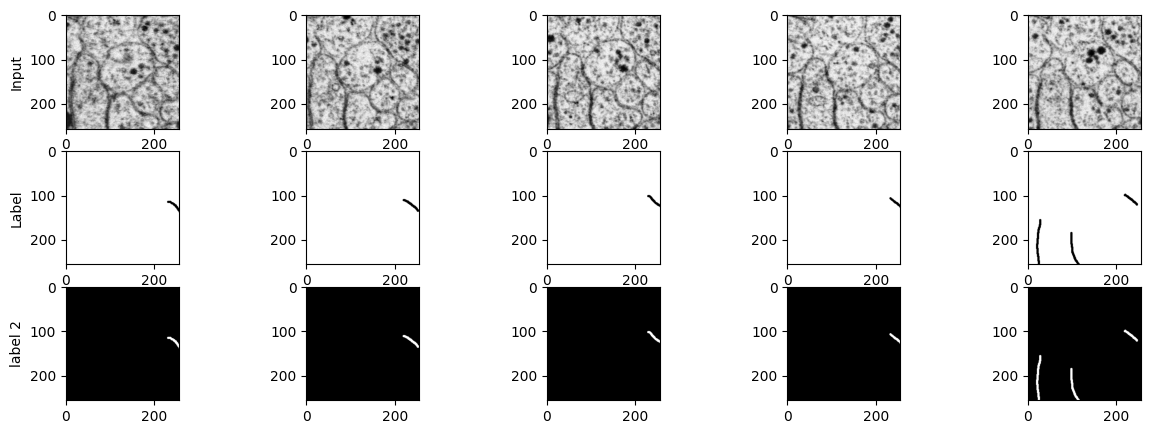

In [16]:
from utilities import visualize_3d_slice
import matplotlib.pyplot as plt
k = 4
inputs, labels = valid_dataset[k]
print(inputs.shape, labels.shape)


In [17]:
print(inputs.shape, labels.shape)

torch.Size([1, 5, 256, 256]) torch.Size([2, 5, 256, 256])


In [18]:
torch.sum(labels[1])

tensor(1987.)

In [19]:
np.unique(labels[0, 1].numpy(), return_counts=True)

(array([0., 1.], dtype=float32), array([  250, 65286]))

In [20]:
# takes ~ 30s to run
pred_2d, pred = model(inputs)

In [21]:
pred.shape, pred_2d.shape

(torch.Size([1, 2, 5, 256, 256]), torch.Size([1, 2, 5, 256, 256]))

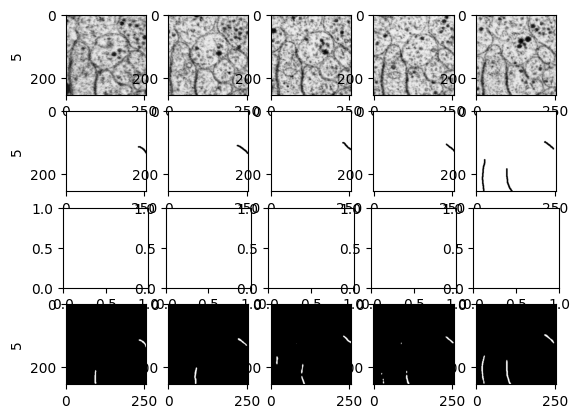

In [22]:
from utilities import *
input_img = inputs[0].numpy()
label_img = labels[0].numpy()
# pred_img = pred[0, 1].detach().numpy()
pred_binary = torch.argmax(pred, dim=1).numpy()[0]
depth, height, width = input_img.shape
fig, ax = plt.subplots(4, depth)
visualize_3d_slice(input_img, ax[0], depth)
visualize_3d_slice(label_img, ax[1], depth)
# visualize_3d_slice(pred_img, ax[2], depth)
visualize_3d_slice(pred_binary, ax[3], depth)

In [15]:
np.unique(pred_binary, return_counts=True)

(array([0]), array([327680]))